<a href="https://colab.research.google.com/github/Ziqi-Li/GIS5122/blob/spring-25/notebooks/Morans%20I%20and%20LISA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Moran's I and LISA


If you have `pysal` installed, you may not need to install these

In [1]:
pip install -q splot

In [2]:
pip install -q libpysal

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd


from libpysal.weights.contiguity import Queen
from splot.esda import moran_scatterplot,plot_moran,lisa_cluster
from esda.moran import Moran, Moran_Local
import splot

In [4]:
# Load example florida geospatial data

path = "https://raw.githubusercontent.com/Ziqi-Li/GEO4162C/1c69903dc7d59e49b31bd1b56b7e84399c9cd5dc/data/fl_pop.geojson"

fl_county_df = gpd.read_file(path)

## Global Moran's I and p-value

Specify a weight matrix

In [5]:
w = Queen.from_dataframe(fl_county_df) #Generate W matrix using Queen contiguity


#w = Rook.from_dataframe(fl_county_df) #Generate W matrix using Rook contiguity


w.transform = 'r' #Row-standardization of the weight matrix

<ipython-input-5-ff6b9aa52fc3>:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(fl_county_df) #Generate W matrix using Queen contiguity


Text(0.5, 1.0, 'Median Monthly Housing Costs ($)')

<Figure size 1920x1440 with 0 Axes>

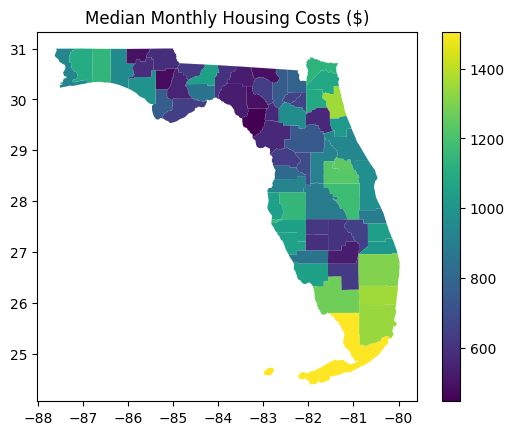

In [6]:
plt.figure(dpi=300)
fl_county_df.plot(fl_county_df['monthly_housing_costs'].values,legend=True)
plt.title('Median Monthly Housing Costs ($)')

Calculate Moran's I

In [16]:
from esda.moran import Moran

housing_costs = fl_county_df['monthly_housing_costs'].values #Get the variable we are interested.

global_moran = Moran(housing_costs, w, permutations=999)

global_moran.I

0.4771382216983452

p-value

In [17]:
global_moran.p_sim # P value based on permutation tests

0.001

This is indicating that the observed positive spatial autocorrelation of the median housing costs map is statistically significant (p<0.05).

In other words, if we assume the pattern to be random, there is around ~0.1% probability that we will observe more patterning than in our real data. so the spatial pattern is very unlikely to be random.  

## Moran Scatterplot

(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.48', ylabel='Density'>,
        <Axes: title={'center': 'Moran Scatterplot (0.48)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

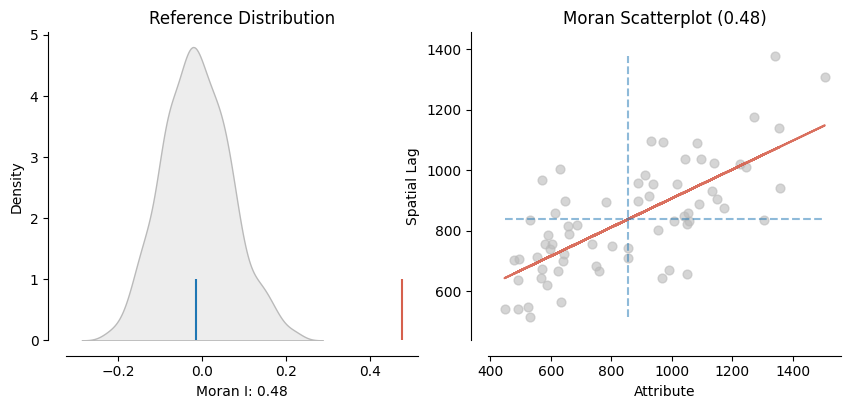

In [9]:
from splot.esda import plot_moran

plot_moran(global_moran,
           zstandard=False, #True the data will be normalized (mean removed and divided by std)
           figsize=(10,4)
          )

The left is the null sampling distribution of Moran's I under assumption of spatial randomness. The blue bar is the position of expected Moran's I value (-1/(n-1)), and the red bar marks the observed Moran's I value (0.48).

The right is a Moran Scatterplot.

## Local Moran's I (LISA)

Generate a better Moran Scatterplot with significance of the local moran's Is.

Color code each county with the quadrant it falls into.
- Red: HH (High values near high values)
- Light Blue: LH
- Yellow: HL
- Blue: LL

Text(0, 0.5, 'Averaged Housing Costs in the Close Neighborhoods')

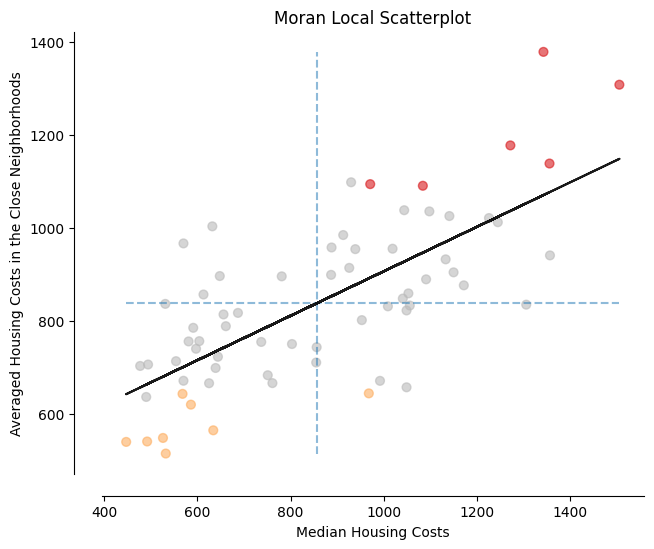

In [10]:
from splot.esda import moran_scatterplot
from esda.moran import Moran_Local

# calculate Moran_Local and plot
moran_local = Moran_Local(housing_costs, w, permutations=999)


fig, ax = moran_scatterplot(moran_local, zstandard=False,p=0.05)

#Labelling
ax.set_xlabel('Median Housing Costs')
ax.set_ylabel('Averaged Housing Costs in the Close Neighborhoods')


Create a hot-spot and cold-spot map.
- HH: High % Bach county surrounded by High % Bach county
- LL: Low-Low
- LH: Low-High
- HL: High-Low
- NS: Non-significant (p>0.05)

(<Figure size 600x600 with 1 Axes>, <Axes: >)

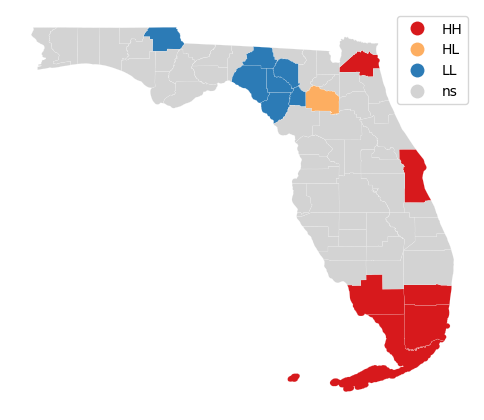

In [11]:
from splot.esda import lisa_cluster

lisa_cluster(moran_loc=moran_local,
             gdf=fl_county_df,
             p = 0.05, # the level of p-value threshold to mask for non-significance
             figsize = (6,6))

## Bivariate LISA

looking at pair-wise relationship between a variable and another variable (neighborhood-averaged)

In [12]:
from esda.moran import Moran_Local_BV

In [13]:
x = fl_county_df['monthly_housing_costs'].values #variable for the current location value
y = fl_county_df['total_population'].values #variable for the neighborhood average


moran_loc_bv = Moran_Local_BV(x, y, w)

Text(0, 0.5, 'Averaged Total Population in the Close Neighborhoods')

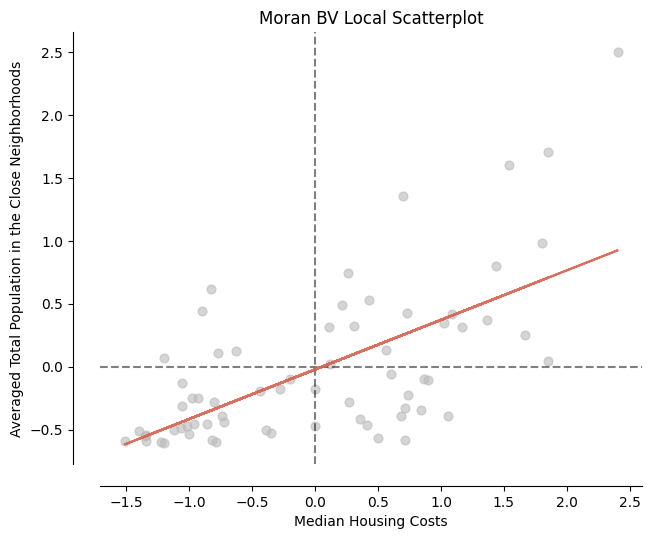

In [14]:
fig, ax = moran_scatterplot(moran_loc_bv, zstandard=None) #note the zstandard variable is not effective due to a bug so the variables are standardized

#Labelling
ax.set_xlabel('Median Housing Costs')
ax.set_ylabel('Averaged Total Population in the Close Neighborhoods')

(<Figure size 600x600 with 1 Axes>, <Axes: >)

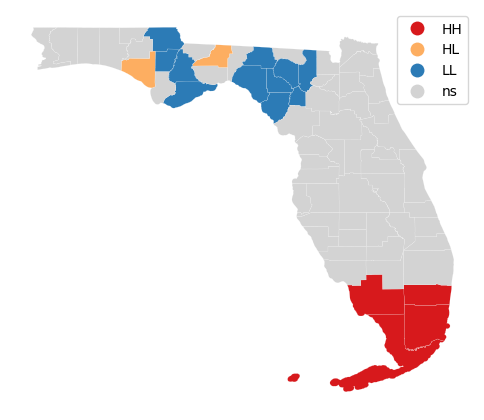

In [15]:
from splot.esda import plot_local_autocorrelation

lisa_cluster(moran_loc=moran_loc_bv,
             gdf=fl_county_df,
             p = 0.05, # the level of p-value threshold to mask for non-significance
             figsize = (6,6))

Bi-variate hot-spot interpretations

- HH: High median housing costs and nearby counties have high population
- LL: Low median housing costs and nearby counties have low population
- LH: Low median housing costs and nearby counties have high population
- HL: High median housing costs and nearby counties have low population